In [1]:
!ls

Generate decoys for test data with NetMHCIIpan.ipynb
Generate decoys with NetMHCIIpan predictions.ipynb
Generate decoys.ipynb
Select and filter Class II MHC mass spec data from IEDB.ipynb
iedb-mhc2-ligands-7-29-2018.csv
mhc2-decoys-7-31-2018.csv.gz


In [2]:
hits = pd.read_csv("iedb-mhc2-ligands-7-29-2018.csv")

In [3]:
hit_seqs = set(hits.peptide)


In [4]:
lengths = [len(p) for p in hit_seqs]
lengths_set = set(lengths)
max_length = max(lengths_set)
length_counts = np.ones(max_length, dtype=int)
for n in lengths:
    length_counts[n - 1] += 1

In [5]:
length_counts

array([   1,    1,    2,    1,    2,    2,    5,   71,  406,  425,  688,
       1226, 2220, 3020, 3098, 2744, 1925, 1175,  694,  467,  299,  176,
        130,   92,   61,   16,   21,   16,   13,   10,   11,   10,    6,
          5,    4,    5,    5,    3,    2,    1,    1,    1,    5,    1,
          1,    2])

In [6]:
length_probs = length_counts / length_counts.sum()

In [7]:
length_probs

array([5.24383849e-05, 5.24383849e-05, 1.04876770e-04, 5.24383849e-05,
       1.04876770e-04, 1.04876770e-04, 2.62191924e-04, 3.72312533e-03,
       2.12899843e-02, 2.22863136e-02, 3.60776088e-02, 6.42894599e-02,
       1.16413214e-01, 1.58363922e-01, 1.62454116e-01, 1.43890928e-01,
       1.00943891e-01, 6.16151023e-02, 3.63922391e-02, 2.44887257e-02,
       1.56790771e-02, 9.22915574e-03, 6.81699004e-03, 4.82433141e-03,
       3.19874148e-03, 8.39014158e-04, 1.10120608e-03, 8.39014158e-04,
       6.81699004e-04, 5.24383849e-04, 5.76822234e-04, 5.24383849e-04,
       3.14630309e-04, 2.62191924e-04, 2.09753540e-04, 2.62191924e-04,
       2.62191924e-04, 1.57315155e-04, 1.04876770e-04, 5.24383849e-05,
       5.24383849e-05, 5.24383849e-05, 2.62191924e-04, 5.24383849e-05,
       5.24383849e-05, 1.04876770e-04])

In [8]:
from pyensembl import ensembl_grch38


In [9]:
genes = [gene for gene in ensembl_grch38.genes() if gene.biotype == "protein_coding"]

In [10]:
genes[0].transcripts

[Transcript(transcript_id=ENST00000612152, name=TSPAN6-204, gene_id=ENSG00000000003, gene_name=TSPAN6, biotype=protein_coding, location=X:100627109-100637104),
 Transcript(transcript_id=ENST00000373020, name=TSPAN6-201, gene_id=ENSG00000000003, gene_name=TSPAN6, biotype=protein_coding, location=X:100628670-100636806),
 Transcript(transcript_id=ENST00000614008, name=TSPAN6-205, gene_id=ENSG00000000003, gene_name=TSPAN6, biotype=protein_coding, location=X:100632063-100637104),
 Transcript(transcript_id=ENST00000496771, name=TSPAN6-203, gene_id=ENSG00000000003, gene_name=TSPAN6, biotype=processed_transcript, location=X:100632541-100636689),
 Transcript(transcript_id=ENST00000494424, name=TSPAN6-202, gene_id=ENSG00000000003, gene_name=TSPAN6, biotype=processed_transcript, location=X:100633442-100639991)]

In [11]:
genes[0].transcripts[0].protein_sequence

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/iskander/Library/Caches/pyensembl/GRCh38/ensembl93/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle


'MLKLYAMFLTLVFLVELVAAIVGFVFRHEIKNSFKNNYEKALKQYNSTGDYRSHAVDKIQNTLHCCGVTDYRDWTDTNYYSEKGFPKSCCKLEDCTPQRDADKVNNELIGIFLAYCLSRAITNNQYEIV'

In [57]:
def concat_protein_sequences(genome=ensembl_grch38, _cache={}):
    if genome in _cache:
        return _cache[genome]
    genes = [gene for gene in genome.genes() if gene.biotype == "protein_coding"]
    all_protein_sequences = []
    for gene in genes:
        curr_transcripts = [
            t for t in gene.transcripts if t.biotype == "protein_coding" 
        ]
        protein_sequences = [
            t.protein_sequence for t in curr_transcripts 
            if  t.protein_sequence is not None 
            and "*" not in t.protein_sequence
            and "X" not in t.protein_sequence
        ]
        if len(protein_sequences) == 0:
            continue 
        all_protein_sequences.append(max(protein_sequences, key=len))
    long_str =  "".join(all_protein_sequences)
    _cache[genome] = long_str
    return long_str

all_proteins = concat_protein_sequences()

In [58]:
len(all_proteins)

11382812

In [59]:
def generate_decoys_for_allele(
        hit_seqs, 
        min_length=9,
        max_length=None,
        decoys_per_hit=100, 
        genome=ensembl_grch38,
        length_pseudocount=2):
    n_hits = len(hit_seqs)
    lengths = [len(p) for p in hit_seqs]
    lengths_set = set(lengths)
    if max_length is None:
        max_length = max(lengths_set)
    length_counts = np.ones(max_length - min_length + 1, dtype=int) * length_pseudocount
    for n in lengths:
        if n < min_length:
            continue
        length_counts[n - min_length] += 1
    length_probs = length_counts / length_counts.sum()
    
    n_decoys = n_hits * decoys_per_hit
    long_protein_str = concat_protein_sequences(genome)
    max_pos = len(long_protein_str)
    random_indices = np.random.randint(0, max_pos, n_decoys, dtype="int64")
    
    random_lengths = np.random.choice(
        a=min_length + np.arange(max_length - min_length + 1),
        size=n_decoys,
        replace=True,
        p=length_probs)
    decoys = []
    for i, n  in zip(random_indices, random_lengths):
        decoys.append(long_protein_str[i:i+n])
    return decoys

def generate_decoys(df_hits, decoys_per_hit=200, genome=ensembl_grch38, length_pseudocount=2, min_length=9):
    columns = {"allele": [], "peptide": []}
    max_length = df_hits.peptide.str.len().max()
    for allele, df_allele in df_hits.groupby("inferred_allele"):
        print("%s (%d)" % (allele, len(df_allele)))
        decoys = generate_decoys_for_allele(
            hit_seqs=set(df_allele.peptide),
            min_length=min_length,
            max_length=max_length,
            decoys_per_hit=decoys_per_hit,
            genome=genome,
            length_pseudocount=length_pseudocount)
        decoy_lengths = [len(p) for p in decoys]
        print("==> generated %d decoys (min length=%d, max length=%d, mean length=%f)" % (
            len(decoys),
            min(decoy_lengths),
            max(decoy_lengths),
            np.mean(decoy_lengths)))
        
        columns["allele"].extend([allele] * len(decoys))
        columns["peptide"].extend(decoys)
    df_decoys = pd.DataFrame(columns)
    return df_decoys


In [60]:
df_decoys = generate_decoys(df_hits=hits, decoys_per_hit=50)

HLA-DPA1*01:03/DPB1*02:01 (12)
==> generated 600 decoys (min length=9, max length=46, mean length=25.721667)
HLA-DPA1*01:03/DPB1*04:01 (4)
==> generated 200 decoys (min length=9, max length=46, mean length=26.380000)
HLA-DQA1*01:01/DQB1*05:01 (33)
==> generated 1650 decoys (min length=9, max length=46, mean length=24.415758)
HLA-DQA1*01:02/DQB1*03:01 (6)
==> generated 300 decoys (min length=9, max length=46, mean length=26.243333)
HLA-DQA1*01:02/DQB1*05:01 (1)
==> generated 50 decoys (min length=9, max length=45, mean length=24.080000)
HLA-DQA1*01:02/DQB1*06:02 (55)
==> generated 2600 decoys (min length=9, max length=46, mean length=23.087692)
HLA-DQA1*01:02/DQB1*06:04 (1)
==> generated 50 decoys (min length=9, max length=46, mean length=27.980000)
HLA-DQA1*02:01/DQB1*02:02 (7355)
==> generated 367050 decoys (min length=9, max length=46, mean length=14.812241)
HLA-DQA1*03:01/DQB1*02:01 (13)
==> generated 650 decoys (min length=9, max length=46, mean length=26.435385)
HLA-DQA1*03:01/DQB

In [61]:
alleles = df_decoys.allele.unique()

In [62]:
from mhctools import NetMHCIIpan
allele_to_predictors = {allele: NetMHCIIpan(alleles=[allele]) for allele in alleles}

INFO:mhctools.base_commandline_predictor:Skipping allele DRB5_0108N: The suffix 'N' of 'DRB5*0108N' was not parsed
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB30101	BoLA-DRA-DRB30101: Allele has too many parts: DRA-DRB30101	BoLA-DRA-DRB30101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31101	BoLA-DRA-DRB31101: Allele has too many parts: DRA-DRB31101	BoLA-DRA-DRB31101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31501	BoLA-DRA-DRB31501: Allele has too many parts: DRA-DRB31501	BoLA-DRA-DRB31501
INFO:mhctools.base_commandline_predictor:Skipping allele DRB5_0108N: The suffix 'N' of 'DRB5*0108N' was not parsed
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB30101	BoLA-DRA-DRB30101: Allele has too many parts: DRA-DRB30101	BoLA-DRA-DRB30101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31101	BoLA-DRA-DRB31101: Allele has too many parts: DRA-DRB31101	BoLA-DRA-DRB31101
INFO:mhcto

INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31101	BoLA-DRA-DRB31101: Allele has too many parts: DRA-DRB31101	BoLA-DRA-DRB31101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31501	BoLA-DRA-DRB31501: Allele has too many parts: DRA-DRB31501	BoLA-DRA-DRB31501
INFO:mhctools.base_commandline_predictor:Skipping allele DRB5_0108N: The suffix 'N' of 'DRB5*0108N' was not parsed
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB30101	BoLA-DRA-DRB30101: Allele has too many parts: DRA-DRB30101	BoLA-DRA-DRB30101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31101	BoLA-DRA-DRB31101: Allele has too many parts: DRA-DRB31101	BoLA-DRA-DRB31101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31501	BoLA-DRA-DRB31501: Allele has too many parts: DRA-DRB31501	BoLA-DRA-DRB31501
INFO:mhctools.base_commandline_predictor:Skipping allele DRB5_0108N: The suffix 'N' of 'DRB5*0108N' was not parsed
INFO:mhcto

INFO:mhctools.base_commandline_predictor:Skipping allele DRB5_0108N: The suffix 'N' of 'DRB5*0108N' was not parsed
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB30101	BoLA-DRA-DRB30101: Allele has too many parts: DRA-DRB30101	BoLA-DRA-DRB30101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31101	BoLA-DRA-DRB31101: Allele has too many parts: DRA-DRB31101	BoLA-DRA-DRB31101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31501	BoLA-DRA-DRB31501: Allele has too many parts: DRA-DRB31501	BoLA-DRA-DRB31501
INFO:mhctools.base_commandline_predictor:Skipping allele DRB5_0108N: The suffix 'N' of 'DRB5*0108N' was not parsed
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB30101	BoLA-DRA-DRB30101: Allele has too many parts: DRA-DRB30101	BoLA-DRA-DRB30101
INFO:mhctools.base_commandline_predictor:Skipping allele BoLA-DRA-DRB31101	BoLA-DRA-DRB31101: Allele has too many parts: DRA-DRB31101	BoLA-DRA-DRB31101
INFO:mhcto

In [63]:
allele_to_predictors

{'HLA-DPA1*01:03/DPB1*02:01': NetMHCIIpan(alleles=['HLA-DPA1*01:03-DPB1*02:01'], default_peptide_lengths=[15, 16, 17, 18, 19, 20]),
 'HLA-DPA1*01:03/DPB1*04:01': NetMHCIIpan(alleles=['HLA-DPA1*01:03-DPB1*04:01'], default_peptide_lengths=[15, 16, 17, 18, 19, 20]),
 'HLA-DQA1*01:01/DQB1*05:01': NetMHCIIpan(alleles=['HLA-DQA1*01:01-DQB1*05:01'], default_peptide_lengths=[15, 16, 17, 18, 19, 20]),
 'HLA-DQA1*01:02/DQB1*03:01': NetMHCIIpan(alleles=['HLA-DQA1*01:02-DQB1*03:01'], default_peptide_lengths=[15, 16, 17, 18, 19, 20]),
 'HLA-DQA1*01:02/DQB1*05:01': NetMHCIIpan(alleles=['HLA-DQA1*01:02-DQB1*05:01'], default_peptide_lengths=[15, 16, 17, 18, 19, 20]),
 'HLA-DQA1*01:02/DQB1*06:02': NetMHCIIpan(alleles=['HLA-DQA1*01:02-DQB1*06:02'], default_peptide_lengths=[15, 16, 17, 18, 19, 20]),
 'HLA-DQA1*01:02/DQB1*06:04': NetMHCIIpan(alleles=['HLA-DQA1*01:02-DQB1*06:04'], default_peptide_lengths=[15, 16, 17, 18, 19, 20]),
 'HLA-DQA1*02:01/DQB1*02:02': NetMHCIIpan(alleles=['HLA-DQA1*02:01-DQB1*02:0

In [64]:
netmhciipan_predictions = {}

for (allele, df_allele) in df_decoys.groupby("allele"):
    peptides = list(df_allele.peptide)
    print("%s (n=%d)" % (allele, len(df_allele)))
    pred = allele_to_predictors[allele].predict_peptides(peptides)
    netmhciipan_predictions[allele] = pred

HLA-DPA1*01:03/DPB1*02:01 (n=600)


INFO:mhctools.process_helpers:Ran 1 commands in 10.8760 seconds


HLA-DPA1*01:03/DPB1*04:01 (n=200)


INFO:mhctools.process_helpers:Ran 1 commands in 3.8102 seconds


HLA-DQA1*01:01/DQB1*05:01 (n=1650)


INFO:mhctools.process_helpers:Ran 1 commands in 27.2423 seconds


HLA-DQA1*01:02/DQB1*03:01 (n=300)


INFO:mhctools.process_helpers:Ran 1 commands in 5.5673 seconds


HLA-DQA1*01:02/DQB1*05:01 (n=50)


INFO:mhctools.process_helpers:Ran 1 commands in 1.0403 seconds


HLA-DQA1*01:02/DQB1*06:02 (n=2600)


INFO:mhctools.process_helpers:Ran 1 commands in 44.5744 seconds


HLA-DQA1*01:02/DQB1*06:04 (n=50)


INFO:mhctools.process_helpers:Ran 1 commands in 1.5141 seconds


HLA-DQA1*02:01/DQB1*02:02 (n=367050)


INFO:mhctools.process_helpers:Ran 37 commands in 1693.9045 seconds


HLA-DQA1*03:01/DQB1*02:01 (n=650)


INFO:mhctools.process_helpers:Ran 1 commands in 17.9382 seconds


HLA-DQA1*03:01/DQB1*03:02 (n=950)


INFO:mhctools.process_helpers:Ran 1 commands in 18.8367 seconds


HLA-DQA1*05:01/DQB1*02:01 (n=214750)


INFO:mhctools.process_helpers:Ran 22 commands in 1055.2396 seconds


HLA-DQA1*05:01/DQB1*03:02 (n=950)


INFO:mhctools.process_helpers:Ran 1 commands in 17.7287 seconds


HLA-DQA1*05:05/DQB1*03:01 (n=371550)


INFO:mhctools.process_helpers:Ran 38 commands in 1930.5847 seconds


HLA-DRA1*01:01/DRB1*01:01 (n=178850)


INFO:mhctools.process_helpers:Ran 18 commands in 57753.3324 seconds


HLA-DRA1*01:01/DRB1*01:02 (n=300)


INFO:mhctools.process_helpers:Ran 1 commands in 5.2295 seconds


HLA-DRA1*01:01/DRB1*01:03 (n=7500)


INFO:mhctools.process_helpers:Ran 1 commands in 92.5820 seconds


HLA-DRA1*01:01/DRB1*03:01 (n=9200)


INFO:mhctools.process_helpers:Ran 1 commands in 104.5592 seconds


HLA-DRA1*01:01/DRB1*04:01 (n=59000)


INFO:mhctools.process_helpers:Ran 6 commands in 285.8440 seconds


HLA-DRA1*01:01/DRB1*04:02 (n=2000)


INFO:mhctools.process_helpers:Ran 1 commands in 32.1879 seconds


HLA-DRA1*01:01/DRB1*04:04 (n=2700)


INFO:mhctools.process_helpers:Ran 1 commands in 38.6597 seconds


HLA-DRA1*01:01/DRB1*04:05 (n=1700)


INFO:mhctools.process_helpers:Ran 1 commands in 25.7416 seconds


HLA-DRA1*01:01/DRB1*08:01 (n=24300)


INFO:mhctools.process_helpers:Ran 3 commands in 162.4868 seconds


HLA-DRA1*01:01/DRB1*09:01 (n=900)


INFO:mhctools.process_helpers:Ran 1 commands in 17.2663 seconds


HLA-DRA1*01:01/DRB1*10:01 (n=11900)


INFO:mhctools.process_helpers:Ran 2 commands in 111.2515 seconds


HLA-DRA1*01:01/DRB1*11:01 (n=5200)


INFO:mhctools.process_helpers:Ran 1 commands in 59.9228 seconds


HLA-DRA1*01:01/DRB1*11:04 (n=1200)


INFO:mhctools.process_helpers:Ran 1 commands in 19.2151 seconds


HLA-DRA1*01:01/DRB1*13:01 (n=1200)


INFO:mhctools.process_helpers:Ran 1 commands in 19.2551 seconds


HLA-DRA1*01:01/DRB1*13:02 (n=1100)


INFO:mhctools.process_helpers:Ran 1 commands in 18.2489 seconds


HLA-DRA1*01:01/DRB1*15:01 (n=32900)


INFO:mhctools.process_helpers:Ran 4 commands in 164.4450 seconds


HLA-DRA1*01:01/DRB3*01:01 (n=200)


INFO:mhctools.process_helpers:Ran 1 commands in 4.5036 seconds


HLA-DRA1*01:01/DRB3*02:02 (n=550)


INFO:mhctools.process_helpers:Ran 1 commands in 17.0104 seconds


HLA-DRA1*01:01/DRB3*03:01 (n=150)


INFO:mhctools.process_helpers:Ran 1 commands in 3.4837 seconds


HLA-DRA1*01:01/DRB5*01:01 (n=10300)


INFO:mhctools.process_helpers:Ran 2 commands in 136.9722 seconds


In [ ]:
# filter out any sequences contained by hits or which contain hits
allele_to_hit_peptides = {}
for allele, hits_df in hits.groupby("inferred_allele"):
    allele_to_hit_peptides[allele] = set(hits_df.peptide)
mask = np.ones(len(df_decoys), dtype=bool)
for i, (allele, peptide) in enumerate(zip(df_decoys.allele, df_decoys.peptide)):
    if i % 1000 == 0:
        print("%d/%d" % (i + 1, len(df_decoys)))
    mask[i] = not any([hit_p in peptide for hit_p in allele_to_hit_peptides[allele]])
n_dropped = (~mask).sum()
print("Dropping %d (%f%%) rows due to overlap with hits" % (n_dropped, 100.0 * n_dropped / len(df_decoys)))
df_decoys = df_decoys[mask]

In [107]:
pmhc_to_aff = {}
pmhc_to_pr = {}

In [108]:
for (allele, preds) in netmhciipan_predictions.items():
    for pred in preds:
        pmhc_to_aff[(allele, pred.peptide)] = pred.affinity
        pmhc_to_pr[(allele, pred.peptide)] = pred.percentile_rank

In [68]:
affinities_list_in_same_order_as_df = []
percentile_ranks_list_in_same_order_as_df = []

for allele, peptide in zip(df_decoys.allele, df_decoys.peptide):
    affinities_list_in_same_order_as_df.append(pmhc_to_aff[(allele, peptide)])
    percentile_ranks_list_in_same_order_as_df.append(pmhc_to_pr
df_decoys["netmhciipan32_affinity"] = affinities_list_in_same_order_as_df

1/1312500
1001/1312500
2001/1312500
3001/1312500
4001/1312500
5001/1312500
6001/1312500
7001/1312500
8001/1312500
9001/1312500
10001/1312500
11001/1312500
12001/1312500
13001/1312500
14001/1312500
15001/1312500
16001/1312500
17001/1312500
18001/1312500
19001/1312500
20001/1312500
21001/1312500
22001/1312500
23001/1312500
24001/1312500
25001/1312500
26001/1312500
27001/1312500
28001/1312500
29001/1312500
30001/1312500
31001/1312500
32001/1312500
33001/1312500
34001/1312500
35001/1312500
36001/1312500
37001/1312500
38001/1312500
39001/1312500
40001/1312500
41001/1312500
42001/1312500
43001/1312500
44001/1312500
45001/1312500
46001/1312500
47001/1312500
48001/1312500
49001/1312500
50001/1312500
51001/1312500
52001/1312500
53001/1312500
54001/1312500
55001/1312500
56001/1312500
57001/1312500
58001/1312500
59001/1312500
60001/1312500
61001/1312500
62001/1312500
63001/1312500
64001/1312500
65001/1312500
66001/1312500
67001/1312500
68001/1312500
69001/1312500
70001/1312500
71001/1312500
72001

554001/1312500
555001/1312500
556001/1312500
557001/1312500
558001/1312500
559001/1312500
560001/1312500
561001/1312500
562001/1312500
563001/1312500
564001/1312500
565001/1312500
566001/1312500
567001/1312500
568001/1312500
569001/1312500
570001/1312500
571001/1312500
572001/1312500
573001/1312500
574001/1312500
575001/1312500
576001/1312500
577001/1312500
578001/1312500
579001/1312500
580001/1312500
581001/1312500
582001/1312500
583001/1312500
584001/1312500
585001/1312500
586001/1312500
587001/1312500
588001/1312500
589001/1312500
590001/1312500
591001/1312500
592001/1312500
593001/1312500
594001/1312500
595001/1312500
596001/1312500
597001/1312500
598001/1312500
599001/1312500
600001/1312500
601001/1312500
602001/1312500
603001/1312500
604001/1312500
605001/1312500
606001/1312500
607001/1312500
608001/1312500
609001/1312500
610001/1312500
611001/1312500
612001/1312500
613001/1312500
614001/1312500
615001/1312500
616001/1312500
617001/1312500
618001/1312500
619001/1312500
620001/131

1094001/1312500
1095001/1312500
1096001/1312500
1097001/1312500
1098001/1312500
1099001/1312500
1100001/1312500
1101001/1312500
1102001/1312500
1103001/1312500
1104001/1312500
1105001/1312500
1106001/1312500
1107001/1312500
1108001/1312500
1109001/1312500
1110001/1312500
1111001/1312500
1112001/1312500
1113001/1312500
1114001/1312500
1115001/1312500
1116001/1312500
1117001/1312500
1118001/1312500
1119001/1312500
1120001/1312500
1121001/1312500
1122001/1312500
1123001/1312500
1124001/1312500
1125001/1312500
1126001/1312500
1127001/1312500
1128001/1312500
1129001/1312500
1130001/1312500
1131001/1312500
1132001/1312500
1133001/1312500
1134001/1312500
1135001/1312500
1136001/1312500
1137001/1312500
1138001/1312500
1139001/1312500
1140001/1312500
1141001/1312500
1142001/1312500
1143001/1312500
1144001/1312500
1145001/1312500
1146001/1312500
1147001/1312500
1148001/1312500
1149001/1312500
1150001/1312500
1151001/1312500
1152001/1312500
1153001/1312500
1154001/1312500
1155001/1312500
1156001/

Dropping 922 (0.070248%) rows due to overlap with hits


In [91]:
df_decoys.to_csv("mhc2-decoys-50x-netmhciipan-8-3-2018.csv", index=False)

In [72]:
!head mhc2-decoys-50x-netmhciipan-8-3-2018.csv

allele,peptide,netmhciipan32_affinity
HLA-DPA1*01:03/DPB1*02:01,SDFYQSNFTIDNQEQSGNDS,516.87
HLA-DPA1*01:03/DPB1*02:01,AGKSNPTFYLQKGFQTYVLRKKP,95.76
HLA-DPA1*01:03/DPB1*02:01,DWIKKIIGSKGMAALGVLESDLPSAVTLLKN,362.07
HLA-DPA1*01:03/DPB1*02:01,YEVVYQIGTETRSDFYDIVLVATPLNRKMSNITFLNFDPPIEEFHQ,53.23
HLA-DPA1*01:03/DPB1*02:01,RVEDFQQHSQKLLSEETPSAAELQDLLDVSFEFDVELPQ,130.47
HLA-DPA1*01:03/DPB1*02:01,EKESEQEPLVRALEAGGC,5539.82
HLA-DPA1*01:03/DPB1*02:01,REEGPFPCPECGKVFLHNSVLTEHGKIHLLEPPRKKAPR,241.0
HLA-DPA1*01:03/DPB1*02:01,WESKSKPTTLKPIILNEIVDAHKEKIKEVIMKESVAPTEHLRLYD,176.48
HLA-DPA1*01:03/DPB1*02:01,CLLCRKAVRLFDTPQAKKDGMRLTPFS,700.99


In [82]:
len(set((zip(hits.inferred_allele, hits.peptide))).intersection(set(zip(df_decoys.allele, df_decoys.peptide))))

83

In [92]:
import seaborn
from matplotlib import pyplot

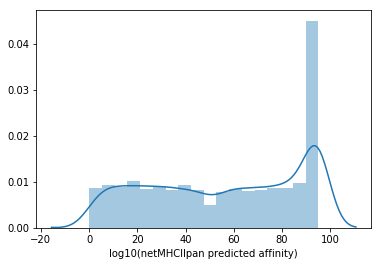

In [105]:
seaborn.distplot([p.percentile_rank for p in preds])
pyplot.xlabel("log10(netMHCIIpan predicted affinity)")

1.4

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>